# HCIPY sanity checks:
Looking into if we understand the units 

In [1]:
from hcipy import *
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
# These modules are used for animating some oåf the graphs in our notebook.
from matplotlib import animation, rc
from IPython.display import HTML

from hcipy import atmosphere
from hcipy import fourier

%matplotlib inline

## Thought experiment, the circle

In [4]:
# equation for area of a circle:
def area_r(r):
    return np.pi*r**2

def area_tri(r, d):
    # require that d <= R
    if d > r:
        return 0
    if d < -r:
        return 0
    # find the angle of the trianlgle
    ang = np.arccos(d/r)
    # find the half base of the triangle
    b = r*np.sin(ang)
    # area of triangle is half base times height
    return b*d

def area_sect(r,d):
    # require that d <= R
    if d > r:
        return 0
    if d < -r:
        return area_r(r)
    # find the angle of the trianlgle
    ang = np.arccos(d/r)
    # since ang is in radians, can just:
    return ang*r**2

def area_ratios(r,d):
    A_tot = area_r(r)
    A_shard = area_sect(r,d) - area_tri(r,d)
    return A_shard, A_tot - A_shard

Text(0.5, 1.0, 'Circle area ratios given offset from center, D')

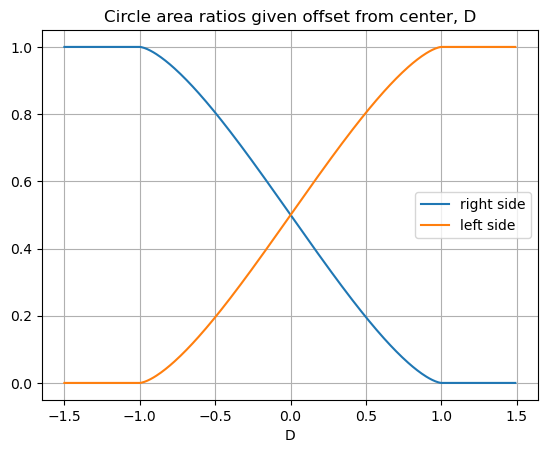

In [5]:
# make a list of possible offsets
#graph the ratios given tip offsets
A_tot = area_r(1)
tips = np.arange(-1.5, 1.5, 0.01) # these are in lambda/D units
tip_ratios = np.array([area_ratios(1, t) for t in tips])
plt.plot(tips, tip_ratios[:,0]/A_tot, label="right side")
plt.plot(tips, tip_ratios[:,1]/A_tot, label="left side")
plt.grid()
plt.xlabel("D")
plt.legend()
plt.title("Circle area ratios given offset from center, D")

In [6]:
# how does this change with offsets due to modulation?
# could look at it like a sum, 


# FW of lambda/D => would have area o 2, one lambda p2v of tip, .25 RMS of tilt
# physical scales and size of PSF

## Test 1

zero to lambda wavefront error, propagate from phasefront to psf, check on it 

In [2]:
import sim_sparkle as smsp
reload(smsp)

<module 'sim_sparkle' from '/home/eden/code/sparkles/sim/sim_sparkle.py'>

In [4]:
# setup MagAO-X system
pupil_grid, pwfs_grid, magellan_aperture = smsp.create_mag_pupil()
deformable_mirror = smsp.create_DM(pupil_grid)
mpwfs, camera = smsp.create_mod_PWFS(pupil_grid, pwfs_grid)
# wfs
wf = smsp.create_wf(magellan_aperture)
wfs_pywfs = smsp.create_pwfs(mpwfs, wf)
image_ref = smsp.mod_forward_int(wfs_pywfs)

In [5]:
## Start up for phase stuff
# creating atmospheric layers
ml_atmsph = smsp.LCO_atmosphere(pupil_grid)
# getting out phase from our multilayer atmosphere
phase = smsp.atms_phase(ml_atmsph)
# filter this phase to make it
phase_res = smsp.filtered_atmosphere(phase, pupil_grid)

# constructing a new optical element that adds phase tp the system
ao = PhaseApodizer(np.real(phase_res))

In [6]:
# how  to calculate strehl

def calc_strehl_psf(psf, psf_abbr):
    strl = np.max(psf_abbr)/np.max(psf)
    return strl

def calc_strl_fitting(phase_abbr, magellan_aperture, wav):
    # RMS is stdv only if you subtract of mean
    phase = phase_abbr - np.mean(phase_abbr[magellan_aperture>0])
    # expect RMS to be under 1
    p2v = np.max(phase) + np.abs(np.min(phase)) 
    RMS = np.sqrt(np.mean(np.square(phase[magellan_aperture>0])))
    RMS_rad = RMS * (np.sqrt(2))
    stdv = np.std(phase[magellan_aperture>0])
    strl_apprx = np.exp(-RMS**2)
    print(f"P2V    : {p2v}")
    print(f"P2V/2pi: {p2v / (2*np.pi)}")
    print(f"RMS    : {RMS}")
    print(f"RMS rad: {RMS_rad}")
    print(f"STDV   : {stdv}")
    return strl_apprx

# ratio of peak pixels
# RMS^2 e^- power

### Unaberrated PSF

In [7]:
# TEST: reference PSF - unaberrated system 
# take the phase
wf = smsp.create_wf(magellan_aperture)
# proagrate to the mirror
prop, norm = smsp.init_prop(pupil_grid, wf)
# find the psf
psf = prop(deformable_mirror(wf)).power # this DM is zeroed and has no aberrations
# does the RMS error match what we expect in terms of strehl?

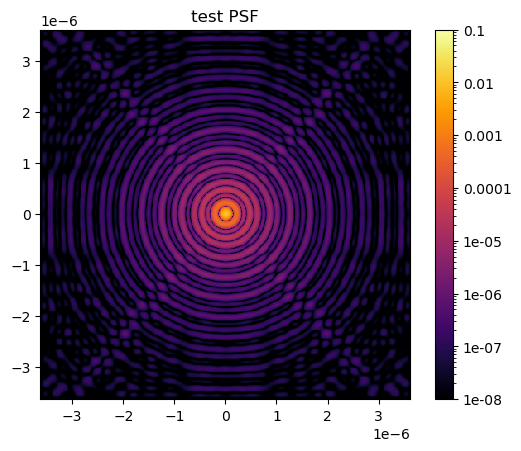

In [8]:
plt.title("test PSF")
imshow_psf(psf) 

In [53]:
# STREHL CALCULATIONS
print("Peak ratio STREHL: ", calc_strehl_psf(psf, psf))
# want the phase: zern_dm(wf)
zern_dm.flatten()
phase = zern_dm(wf).phase
print("Fitting error STREHL: ", calc_strl_fitting(phase, magellan_aperture, smsp.wavelength_wfs))
# want ten microns of amplitude to be reasonable, an actual mappyig, wil take out wavelneght dependence later
# normlized it will be "one"

Peak ratio STREHL:  1.0
P2V: 0.0
P2V di rad: 0.0
RMS    : 0.0
RMS rad: 0.0
Fitting error STREHL:  1.0


### aberrate this PSF

In [9]:
# add in zernike modes
n_z_modes = 100
zern_dm = smsp.create_DM_zern(pupil_grid, n_z_modes, magellan_aperture)

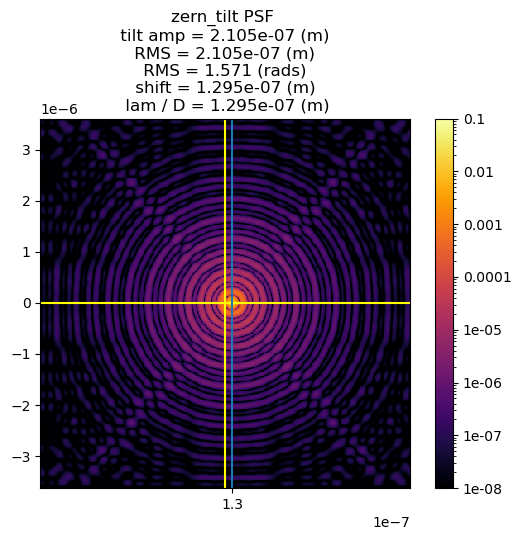

In [73]:
#REPEAT, but for the zernike modes
wf = smsp.create_wf(magellan_aperture)
# proagrate to the mirror
amp = 1*smsp.wavelength_wfs/4 # could also do nm here
#amp = 10e-9
zern_dm.flatten()
zern_dm.actuators[0] = amp/2 #amp*.5/(2*np.pi)  # this is OPD, so has 2*pi
RMS = np.std(zern_dm.opd[magellan_aperture>0])
phase_RMS = 2 * np.pi / smsp.wavelength_wfs * np.std(zern_dm.opd[magellan_aperture>0])
# here we expect to normalize to RMS or amplitude
# multiplying by the magelllean mask witll change the normalization
# find the psf
prop_f = prop(zern_dm(wf))
psf_z = prop_f.power # this DM is zeroed and has no aberrations
x = prop_f.grid.points[np.argmax(psf_z)][0]
# does the RMS error match what we expect in terms of strehl?
# we can try by aberrating with the generic atmosphere, then the residual
plt.title(f"zern_tilt PSF \n tilt amp = {amp} (m) \n RMS = {np.round(phase_RMS, 3)} (rads) \n shift = {np.round(x, 3+7)} (m) \n lam / D = {np.round(smsp.spatial_resolution, 3+7)} (m)")
imshow_psf(psf_z)
plt.xticks([x])
plt.axvline(0, c='yellow')
plt.axhline(0, c='yellow')
plt.axvline(x)

In [50]:
prop_f.grid.points[np.argmax(psf_z)]

array([2.42884615e-07, 0.00000000e+00])

In [30]:
np.sqrt(psf_z.shape[0])

448.0

In [25]:
pupil_grid[np.argmax(psf_z)]

IndexError: index 100591 is out of bounds for axis 0 with size 3600

In [87]:
# STREHL CALCULATIONS
print("Peak ratio: ", calc_strehl_psf(psf, psf_z))
# want the phase: zern_dm(wf)
phase = zern_dm(wf).phase
print("Fitting error: ", calc_strl_fitting(phase, magellan_aperture, smsp.wavelength_wfs))
# want ten microns of amplitude to be reasonable, an actual mappyig, wil take out wavelneght dependence later
# normlized it will be "one"

Peak ratio:  0.3315958891505248
P2V    : 3.9066993285084637
P2V/2pi: 0.6217705093059103
RMS    : 1.0
RMS rad: 1.4142135623730951
STDV   : 1.0
Fitting error:  0.36787944117144233


### what about a generic surface aberr

In [ ]:
from hcipy import optics
ptv = 1e-7
surf_abrr = SurfaceAberration(pupil_grid, ptv, smsp.pupil_grid_diameter)

/opt/conda/lib/python3.10/site-packages/hcipy/optics/aberration.py:37: RuntimeWarning: divide by zero encountered in power
  res = Field(grid.as_('polar').r**exponent, grid)


In [23]:
# make a clean wfs
wf = smsp.create_wf(magellan_aperture)
# prop through surface aberrations
psf_a = prop(surf_abrr(wf)).power
# check pfs

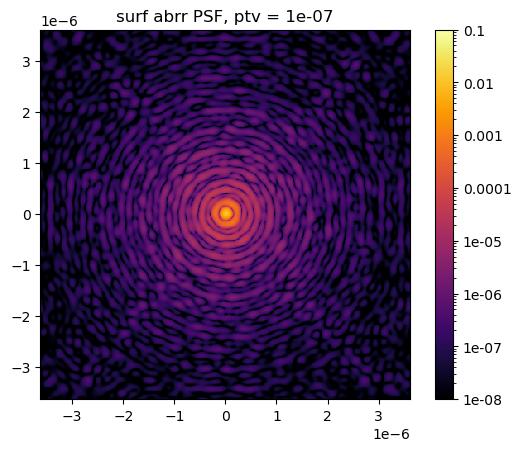

In [24]:
plt.title(f"surf abrr PSF, ptv = {ptv}")
imshow_psf(psf_a)

## PTV to strehl calculations

In [ ]:
# want the normalization of the tilt, this is not the multiplication we expect, it should be the full width half max
# want to know our normalization at each step, or radians

# lambda over/D is the width of PSF